In [80]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
%matplotlib inline

In [81]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')

In [82]:
#req1 = req1[20000:2005000]
#gen_req1 = gen_req1[20000:2005000]
req1.shape,gen_req1.shape

((2005000,), (2255000,))

In [83]:
N = 100 # total ids 
pi = 3.14

LRU

In [84]:
def LRU(y, x, request_time,con):
  [N,I] = x.shape
  J = len(y)
  for j in range(J):
    x_t_j = np.zeros(N)
    file_req_time = np.zeros(N)

    # to find which users are connected to this cache 
    connected_users = []
    for k in range(I):
      if con[k,j] == 1:
        connected_users.append(k)
    for k in range(len(connected_users)):
      x_t_j += x[:,connected_users[k]]
      file_req_time = np.maximum(file_req_time, request_time[:,connected_users[k]])
    x_t_j = np.minimum(np.ones(N),x_t_j)

    a1 = np.transpose(np.logical_and(y[j],np.logical_not(np.logical_and(y[j],np.transpose(x_t_j)))))# file which is not requested but still in the cache
    b1 = np.transpose(np.logical_and(np.transpose(x_t_j),np.logical_not(np.logical_and(y[j],np.transpose(x_t_j))))) # file requested but not in the cache.
    a = np.sum(a1)
    b = np.sum(b1)

    if a>0 and b>0:
      if a>b:
        ind = []
        for k in range(N):
          if a1[k] == 1:
            ind.append(k)
        t = np.zeros(a)
        for k in range(a):
          t[k] = file_req_time[ind[k]]
        replace = (t).argsort()[:b]
        for k in range(b):
          y[j,ind[int(replace[k])]] = 0
        for k in range(N):
          if b1[k] == 1:
            y[j,k] = 1
      
      else:
        for k in range(N):
          if a1[k] == 1:
            y[j,k] = 0
        
        ind = []
        for k in range(N):
          if b1[k] == 1:
            ind.append(k)
        t = np.zeros(b)
        for k in range(b):
          t[k] = file_req_time[ind[k]]
        replace = (t).argsort()[:a]
        for k in range(a):
          y[j,ind[int(replace[k])]] = 1
  return y

LFU

In [85]:
def LFU(y,x,freq,con):
  [N,I] = x.shape
  J = len(y)

  for j in range(J):
    file_freq = np.zeros(N)
    x_t_j = np.zeros(N)

    # to find which users are connected to this cache 
    connected_users = []
    for k in range(I):
      if con[k,j] == 1:
        connected_users.append(k)
    for k in range(len(connected_users)):
      x_t_j += x[:,connected_users[k]]
      file_freq += freq[:,connected_users[k]]
    x_t_j = np.minimum(np.ones(N),x_t_j)

    a1 = np.transpose(np.logical_and(y[j],np.logical_not(np.logical_and(y[j],np.transpose(x_t_j)))))# file which is not requested but still in the cache
    b1 = np.transpose(np.logical_and(np.transpose(x_t_j),np.logical_not(np.logical_and(y[j],np.transpose(x_t_j))))) # file requested but not in the cache.
    a = np.sum(a1)
    b = np.sum(b1)
  
    if a>0 and b>0:
      if a>b:
        ind = []
        for k in range(N):
          if a1[k] == 1:
            ind.append(k)
        t = np.zeros(a)
        for k in range(a):
          t[k] = file_freq[ind[k]]
        replace = (t).argsort()[:b]
        for k in range(b):
          y[j,ind[int(replace[k])]] = 0
        for k in range(N):
          if b1[k] == 1:
            y[j,k] = 1
      else:
        for k in range(N):
          if a1[k] == 1:
            y[j,k] = 0
        ind = []
        for k in range(N):
          if b1[k] == 1:
            ind.append(k)
        t = np.zeros(b)
        for k in range(b):
          t[k] = file_freq[ind[k]]
        replace = (t).argsort()[:a]
        for k in range(a):
          y[j,ind[int(replace[k])]] = 1

  return y

perturbed count

In [86]:
def per_count(eta,count):
  [N,I] = count.shape
  p_count = np.zeros((N,I),dtype = float)
  for i in range(I):
    p_count[:,i] = count[:,i] + (eta*random.normal(0,1,[N,1])).reshape(N)
  return p_count

SINGLE CACHE

In [87]:
I = 1 #users
T = 200000
degree = 1
J = 1 #caches
C = 5
connection = np.array([[1]])
connection.shape

(1, 1)

In [88]:
req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    req[i,j] = req1[(i+1)*(j+1) - 1]
req.shape

(1, 200000)

In [89]:
gen_req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    gen_req[i,j] = gen_req1[(i+1)*(j+1) - 1]
gen_req.shape

(1, 200000)

In [90]:
y_LRU = np.zeros((J,N),dtype = float)
y_LFU = np.zeros((J,N),dtype = float)
y_FTPL = np.zeros((J,N),dtype = float)
y_LSTM = np.zeros((J,N),dtype = float)
y_LSTM[:,:C] = np.ones((J,C),dtype = float)
y_FTPL[:,:C] = np.ones((J,C),dtype = float)
y_LRU[:,:C] = np.ones((J,C),dtype = float)
y_LFU[:,:C] = np.ones((J,C),dtype = float)

count = np.zeros((N,I),dtype = float)

reward_LSTM =  np.zeros(T)
reward_FTPL =  np.zeros(T)
reward_LRU =  np.zeros(T)
reward_LFU =  np.zeros(T)
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
miss_LRU =  0
miss_LSTM =  0
miss_LFU =  0
miss_FTPL =  0


req_time = np.zeros((N,I),dtype = float) 
req_time1 = np.zeros((N,I),dtype = float) 

for t in range(T):
  old_FTPL = []
  old_LRU = []
  old_LFU = []
  old_LSTM = []
  new_FTPL = []
  new_LRU = []
  new_LFU = []
  new_LSTM = []
  for j in range(J):
    for k in range(N):
      old_LRU.append(y_LRU[j,k])
      old_LFU.append(y_LFU[j,k])
      old_FTPL.append(y_FTPL[j,k])
      old_LSTM.append(y_LSTM[j,k])
#  print(old_LRU)
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros(I)
  ireward_LSTM =  np.zeros(I)
  ireward_LFU =  np.zeros(I)
  ireward_FTPL =  np.zeros(I)
  
  for i in range(I):
    temp1 = np.zeros(N)
    temp2 = np.zeros(N)
    temp3 = np.zeros(N)
    temp4 = np.zeros(N)
    connected_cache = []
    for j in range(J):
      if connection[i,j] == 1:
        connected_cache.append(j)
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)


  y_LFU = LFU(y_LFU,x_t,count,connection)
  y_LRU = LRU(y_LRU,x_t,req_time,connection)
  y_LSTM = LRU(y_LSTM,x_t1,req_time1,connection)

  eta = pow(4*pi*np.log(N),-.25)*pow((t+1)/C,.5)
  perturbed_count=per_count(eta,count)

  add = (-perturbed_count[:,0]).argsort()[:C]
  y_FTPL = np.zeros((J,N),dtype = float)
  for k in range(len(add)):
    y_FTPL[0,int(add[k])] = 1 
 
  for j in range(J):
    for k in range(N):
      new_LRU.append(y_LRU[j,k])
      new_LFU.append(y_LFU[j,k])
      new_FTPL.append(y_FTPL[j,k])
      new_LSTM.append(y_LSTM[j,k])
  
#  print(old_LRU)
  miss_FTPL += (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))
  miss_LFU += (np.sum(np.logical_and(new_LFU,np.logical_not(old_LFU))))
  miss_LRU += (np.sum(np.logical_and(new_LRU,np.logical_not(old_LRU))))
  miss_LSTM += (np.sum(np.logical_and(new_LSTM,np.logical_not(old_LSTM))))
  download_LFU.append(miss_LFU)
  download_LRU.append(miss_LRU)
  download_FTPL.append(miss_FTPL)
  download_LSTM.append(miss_LSTM)

  hits_LRU.append(reward_LRUc)
  hits_LFU.append(reward_LFUc)
  hits_FTPL.append(reward_FTPLc)
  hits_LSTM.append(reward_LSTMc)

  if t %10000 == 0:
    print(t,download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t])

0 5 1 1 1
10000 36878 9397 9477 9477
20000 63481 18715 18994 18994
30000 85483 28029 28465 27616
40000 102731 37355 37919 36214
50000 117535 46740 47407 44815
60000 130351 56073 56865 53412
70000 141780 65392 66324 62018
80000 152619 74733 75808 70578
90000 162645 84087 85340 79217
100000 171543 93415 94835 87881
110000 179711 102743 104293 96523
120000 187884 112087 113766 105147
130000 195974 121436 123257 113729
140000 203583 130781 132765 122339
150000 211757 140113 142275 131006
160000 219944 149450 151796 139586
170000 228284 158837 161274 148243
180000 236793 168149 170803 156913
190000 245382 177520 180335 165502


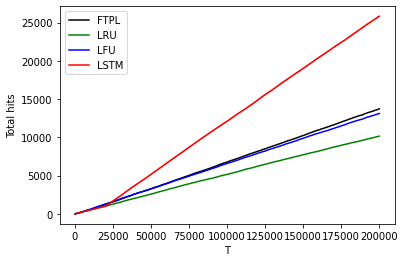

In [91]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('Total hits')
plt.legend()
plt.savefig('Total hits(I=J=1).png')

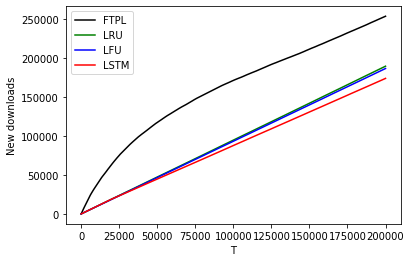

In [92]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('New downloads')
plt.legend()
plt.savefig('New downloads(I=J=1).png')

I = 5 J = 3 d = 2

In [93]:
C = 5
I = 5
J = 3
degree = 3
T = 200000

In [94]:
connection = np.zeros((I,J),dtype = int)
i = 0
for j in range(J):
  x = 0
  while x < degree:
    connection[i,j] = 1
    x += 1
    i += 1
    if i == I:
      i = 0
  i = j+1
connection

array([[1, 0, 0],
       [1, 1, 0],
       [1, 1, 1],
       [0, 1, 1],
       [0, 0, 1]])

In [95]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')
req1 = req1[20000:2005000]
gen_req1 = gen_req1[20000:2005000]

In [96]:
req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    req[i,j] = req1[(i+1)*(j+1) - 1]
req.shape

(5, 200000)

In [97]:
gen_req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    gen_req[i,j] = gen_req1[(i+1)*(j+1) - 1]
gen_req.shape

(5, 200000)

In [98]:
y_LRU = np.zeros((J,N),dtype = float)
y_LFU = np.zeros((J,N),dtype = float)
y_FTPL = np.zeros((J,N),dtype = float)
y_LSTM = np.zeros((J,N),dtype = float)
y_LSTM[:,:C] = np.ones((J,C),dtype = float)
y_FTPL[:,:C] = np.ones((J,C),dtype = float)
y_LRU[:,:C] = np.ones((J,C),dtype = float)
y_LFU[:,:C] = np.ones((J,C),dtype = float)

count = np.zeros((N,I),dtype = float)

reward_LSTM =  np.zeros(T)
reward_FTPL =  np.zeros(T)
reward_LRU =  np.zeros(T)
reward_LFU =  np.zeros(T)
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
miss_LRU =  0
miss_LSTM =  0
miss_LFU =  0
miss_FTPL =  0


req_time = np.zeros((N,I),dtype = float) 
req_time1 = np.zeros((N,I),dtype = float) 

for t in range(T):
  old_FTPL = []
  old_LRU = []
  old_LFU = []
  old_LSTM = []
  new_FTPL = []
  new_LRU = []
  new_LFU = []
  new_LSTM = []
  for j in range(J):
    for k in range(N):
      old_LRU.append(y_LRU[j,k])
      old_LFU.append(y_LFU[j,k])
      old_FTPL.append(y_FTPL[j,k])
      old_LSTM.append(y_LSTM[j,k])
#  print(old_LRU)
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros(I)
  ireward_LSTM =  np.zeros(I)
  ireward_LFU =  np.zeros(I)
  ireward_FTPL =  np.zeros(I)
  
  for i in range(I):
    temp1 = np.zeros(N)
    temp2 = np.zeros(N)
    temp3 = np.zeros(N)
    temp4 = np.zeros(N)
    connected_cache = []
    for j in range(J):
      if connection[i,j] == 1:
        connected_cache.append(j)
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)


  y_LFU = LFU(y_LFU,x_t,count,connection)
  y_LRU = LRU(y_LRU,x_t,req_time,connection)
  y_LSTM = LRU(y_LSTM,x_t1,req_time1,connection)

  eta = pow(4*pi*np.log(N),-.25)*pow((t+1)/C,.5)
  perturbed_count=per_count(eta,count)

  if t%1== 0:
    for j in range(J):
      max_FTPL = np.zeros(N)
      for f in range(N):
        y_FTPL[j,f] = 1
        z_FTPL = np.zeros((I,N), dtype = float)
        for i in range(I):
          for k in range(J):
            if connection[i,k] == 1:
              z_FTPL[i] += y_FTPL[k]
          z_FTPL[i] = np.minimum(np.ones(N),z_FTPL[i].reshape(N))
        max_FTPL[f] += np.dot(z_FTPL[i],perturbed_count[:,i])  
        y_FTPL[j,f] = 0
      f_FTPL = (-max_FTPL).argsort()[:C]
      for k in range (C):
        y_FTPL[j,f_FTPL[k]] = 1
  
  for j in range(J):
    for k in range(N):
      new_LRU.append(y_LRU[j,k])
      new_LFU.append(y_LFU[j,k])
      new_FTPL.append(y_FTPL[j,k])
      new_LSTM.append(y_LSTM[j,k])
  
#  print(old_LRU)
  miss_FTPL += (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))
  miss_LFU += (np.sum(np.logical_and(new_LFU,np.logical_not(old_LFU))))
  miss_LRU += (np.sum(np.logical_and(new_LRU,np.logical_not(old_LRU))))
  miss_LSTM += (np.sum(np.logical_and(new_LSTM,np.logical_not(old_LSTM))))
  download_LFU.append(miss_LFU)
  download_LRU.append(miss_LRU)
  download_FTPL.append(miss_FTPL)
  download_LSTM.append(miss_LSTM)

  hits_LRU.append(reward_LRUc)
  hits_LFU.append(reward_LFUc)
  hits_FTPL.append(reward_FTPLc)
  hits_LSTM.append(reward_LSTMc)

  if t %10000 == 0:
    print(t,download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t])

0 13 9 9 9
10000 20299 83738 84279 81058
20000 37652 167550 168712 162179
30000 53675 251446 253308 243535
40000 69555 335431 338001 325137
50000 84891 419247 422539 406480
60000 99705 502926 507025 487881
70000 114573 586750 591546 569138
80000 129256 670496 675906 650510
90000 143884 754251 760369 731752
100000 158547 837778 844833 813108
110000 173063 921395 929286 894275
120000 187746 1005036 1013736 975662
130000 202435 1088790 1098172 1056939
140000 217299 1172651 1182715 1138102
150000 232039 1256172 1267135 1219274
160000 246639 1339810 1351660 1300866
170000 261240 1423683 1436373 1381872
180000 275728 1507570 1520874 1463247
190000 290220 1591438 1605345 1544321


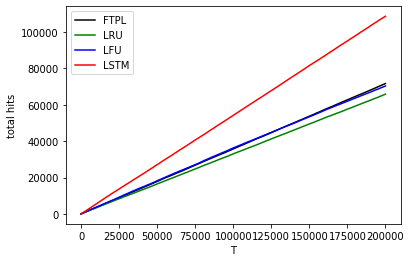

In [99]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('total hits')
plt.legend()
plt.savefig('Total hits(I=5 J=3 d=2).png')

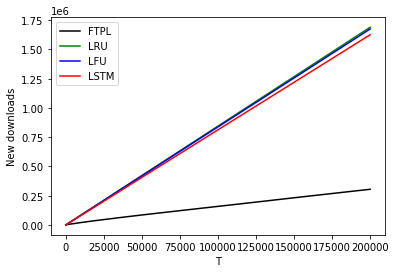

In [100]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('New downloads')
plt.legend()
plt.savefig('New downloads(I=5 J=3 d=2).png')

I = 15 J = 10 d = 7

In [101]:
I = 15
J = 10
C = 10
degree = 7
T = 10000

In [102]:
connection = np.zeros((I,J),dtype = int)
i = 0
for j in range(J):
  x = 0
  while x < degree:
    connection[i,j] = 1
    x += 1
    i += 1
    if i == I:
      i = 0
  i = j+1
connection

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]])

In [103]:
req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    req[i,j] = req1[(i+1)*(j+1) - 1]
req.shape

(15, 10000)

In [104]:
gen_req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    gen_req[i,j] = gen_req1[(i+1)*(j+1) - 1]
gen_req.shape

(15, 10000)

In [105]:
y_LRU = np.zeros((J,N),dtype = float)
y_LFU = np.zeros((J,N),dtype = float)
y_FTPL = np.zeros((J,N),dtype = float)
y_LSTM = np.zeros((J,N),dtype = float)
y_LSTM[:,:C] = np.ones((J,C),dtype = float)
y_FTPL[:,:C] = np.ones((J,C),dtype = float)
y_LRU[:,:C] = np.ones((J,C),dtype = float)
y_LFU[:,:C] = np.ones((J,C),dtype = float)

count = np.zeros((N,I),dtype = float)

reward_LSTM =  np.zeros(T)
reward_FTPL =  np.zeros(T)
reward_LRU =  np.zeros(T)
reward_LFU =  np.zeros(T)
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
miss_LRU =  0
miss_LSTM =  0
miss_LFU =  0
miss_FTPL =  0
req_time = np.zeros((N,I),dtype = float) 
req_time1 = np.zeros((N,I),dtype = float) 

for t in range(T):
  old_FTPL = []
  old_LRU = []
  old_LFU = []
  old_LSTM = []
  new_FTPL = []
  new_LRU = []
  new_LFU = []
  new_LSTM = []
  for j in range(J):
    for k in range(N):
      old_LRU.append(y_LRU[j,k])
      old_LFU.append(y_LFU[j,k])
      old_FTPL.append(y_FTPL[j,k])
      old_LSTM.append(y_LSTM[j,k])
#  print(old_LRU)
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros(I)
  ireward_LSTM =  np.zeros(I)
  ireward_LFU =  np.zeros(I)
  ireward_FTPL =  np.zeros(I)
  
  for i in range(I):
    temp1 = np.zeros(N)
    temp2 = np.zeros(N)
    temp3 = np.zeros(N)
    temp4 = np.zeros(N)
    connected_cache = []
    for j in range(J):
      if connection[i,j] == 1:
        connected_cache.append(j)
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)


  y_LFU = LFU(y_LFU,x_t,count,connection)
  y_LRU = LRU(y_LRU,x_t,req_time,connection)
  y_LSTM = LRU(y_LSTM,x_t1,req_time1,connection)

  eta = pow(4*pi*np.log(N),-.25)*pow((t+1)/C,.5)
  perturbed_count=per_count(eta,count)

  if t%1 == 0:
    for j in range(J):
      max_FTPL = np.zeros(N)
      for f in range(N):
        y_FTPL[j,f] = 1
        z_FTPL = np.zeros((I,N), dtype = float)
        for i in range(I):
          for k in range(J):
            if connection[i,k] == 1:
              z_FTPL[i] += y_FTPL[k]
          z_FTPL[i] = np.minimum(np.ones(N),z_FTPL[i].reshape(N))
        max_FTPL[f] += np.dot(z_FTPL[i],perturbed_count[:,i])  
        y_FTPL[j,f] = 0
      f_FTPL = (-max_FTPL).argsort()[:C]
      for k in range (C):
        y_FTPL[j,f_FTPL[k]] = 1
  
  for j in range(J):
    for k in range(N):
      new_LRU.append(y_LRU[j,k])
      new_LFU.append(y_LFU[j,k])
      new_FTPL.append(y_FTPL[j,k])
      new_LSTM.append(y_LSTM[j,k])
  
#  print(old_LRU)
  miss_FTPL += (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))
  miss_LFU += (np.sum(np.logical_and(new_LFU,np.logical_not(old_LFU))))
  miss_LRU += (np.sum(np.logical_and(new_LRU,np.logical_not(old_LRU))))
  miss_LSTM += (np.sum(np.logical_and(new_LSTM,np.logical_not(old_LSTM))))
  download_LFU.append(miss_LFU)
  download_LRU.append(miss_LRU)
  download_FTPL.append(miss_FTPL)
  download_LSTM.append(miss_LSTM)

  hits_LRU.append(reward_LRUc)
  hits_LFU.append(reward_LFUc)
  hits_FTPL.append(reward_FTPLc)
  hits_LSTM.append(reward_LSTMc)

  if t %1000 == 0:
    print(t,hits_FTPL[t],hits_LFU[t],hits_LRU[t],hits_LSTM[t],download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t])

0 1.0 1.0 1.0 0.0 92 63 63 54
1000 2665.0 2714.0 2477.0 2909.0 13101 60008 60686 58821
2000 5304.0 5313.0 4916.0 5914.0 25545 120110 121516 117443
3000 8003.0 7816.0 7334.0 8950.0 37839 180286 182625 175909
4000 10685.0 10369.0 9803.0 11982.0 50006 240439 243568 234358
5000 13304.0 12879.0 12190.0 15137.0 62149 300925 304747 292410
6000 15986.0 15427.0 14602.0 18129.0 74310 361101 365858 351035
7000 18656.0 17987.0 17103.0 21154.0 86512 421388 426659 409501
8000 21391.0 20550.0 19592.0 24205.0 98684 481568 487549 467928
9000 24100.0 23003.0 21989.0 27263.0 110857 541846 548597 526060


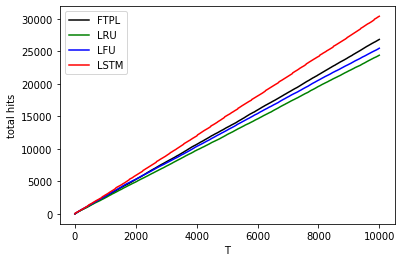

In [106]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('total hits')
plt.legend()
plt.savefig('Total hits(I=15 J=10 d=7).png')

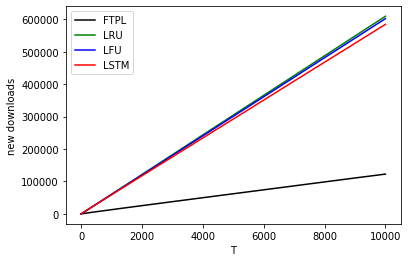

In [107]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('new downloads')
plt.legend()
plt.savefig('New downloads(I=15 J=10 d=7).png')